# Clip tidal model constituents to smaller extent

This notebook provides code for clipping the NetCDF tidal consituent files to a smaller spatial extent.
This greatly improves `pyTMD`'s tide modelling performance by reducing the time taken to read and interpolate the input NetCDF files.

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [2]:
# pip install -r requirements.in --quiet

In [3]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from dea_tools.validation import eval_metrics
from dea_tools.coastal import model_tides

## Set desired output extents
In Australia, use our Collection 3 Albers grid

In [4]:
# Get desired output area and buffer by 1 degree
dea_albers = gpd.read_file('https://data.dea.ga.gov.au/derivative/ga_summary_grid_c3.geojson')
minx, miny, maxx, maxy = dea_albers.geometry.buffer(1).total_bounds
minx, miny, maxx, maxy

/tmp/ipykernel_29779/3018110233.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  minx, miny, maxx, maxy = dea_albers.geometry.buffer(1).total_bounds


(108.27938425718472, -47.2300021066206, 158.04487140636076, -6.213661201687508)

# FES2022

In [ ]:
# Load, clip and export FES2022 data
for path in glob.glob('/gdata1/data/tide_models/fes2022b/*/*.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## FES2014

In [ ]:
# Load, clip and export FES2014 data
for path in glob.glob('/gdata1/data/tide_models/fes2014/*/*.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## FES2012

In [ ]:
# Load, clip and export FES2012 data
for path in glob.glob('/gdata1/data/tide_models/fes2012/data/*FES2012_SLEV.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## TPXO9

In [ ]:
# First open grid NetCDF and determine indices (nx, ny) of desired lat/lon extents
grid = xr.open_mfdataset(
        "/gdata1/data/tide_models/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc"
    )
nx_min = int(grid.nx.where((grid.lon_u > minx) & (grid.lon_u < maxx)).min().compute().item())
nx_max = int(grid.nx.where((grid.lon_u > minx) & (grid.lon_u < maxx)).max().compute().item())
ny_min = int(grid.ny.where((grid.lat_u > miny) & (grid.lat_u < maxy)).min().compute().item())
ny_max = int(grid.ny.where((grid.lat_u > miny) & (grid.lat_u < maxy)).max().compute().item())

In [ ]:
# Load, clip and export TPXO9 data
for path in glob.glob("/gdata1/data/tide_models/TPXO9_atlas_v5/*.nc"):
    print(path)
    xr.open_mfdataset(path).sel(
        nx=slice(nx_min, nx_max), ny=slice(ny_min, ny_max)
    ).to_netcdf(path.replace("tide_models", "tide_models_clipped"), mode="w")

## TPXO8

In [ ]:
# First open grid NetCDF and determine indices (nx, ny) of desired lat/lon extents
grid = xr.open_mfdataset(
        "/gdata1/data/tide_models/TPXO8_atlas_v1/hf.k1_tpxo8_atlas_30c_v1.nc"
    )
nx_min = int(grid.nx.where((grid.lon_z > minx) & (grid.lon_z < maxx)).min().compute().item())
nx_max = int(grid.nx.where((grid.lon_z > minx) & (grid.lon_z < maxx)).max().compute().item())
ny_min = int(grid.ny.where((grid.lat_z > miny) & (grid.lat_z < maxy)).min().compute().item())
ny_max = int(grid.ny.where((grid.lat_z > miny) & (grid.lat_z < maxy)).max().compute().item())


In [ ]:
# Load, clip and export TPXO9 data
for path in glob.glob("/gdata1/data/tide_models/TPXO8_atlas_v1/*30*.nc"):
    print(path)
    xr.open_mfdataset(path).sel(
        nx=slice(nx_min, nx_max), ny=slice(ny_min, ny_max)
    ).to_netcdf(path.replace("tide_models", "tide_models_clipped"), mode="w")

## EOT20

In [ ]:
# Load, clip and export EOT20 data
for path in glob.glob('/gdata1/data/tide_models/EOT20/*/*eot20.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## HAMTIDE

In [ ]:
# Load, clip and export HAMTIDE data
for path in glob.glob("/gdata1/data/tide_models/hamtide/*.nc"):
    print(path)
    try:
        xr.open_mfdataset(path).sel(
            LON=slice(minx, maxx), LAT=slice(miny, maxy)
        ).to_netcdf(path.replace("tide_models", "tide_models_clipped"), mode="w")
    except KeyError:
        # Swap X Y index dims to lat and lon, clip, then revert back
        xr.open_mfdataset(path).swap_dims(Y="lat", X="lon").sel(
            lon=slice(minx, maxx), lat=slice(miny, maxy)
        ).swap_dims(lat="Y", lon="X").to_netcdf(
            path.replace("tide_models", "tide_models_clipped"), mode="w"
        )

## Verify model outputs are the same across clipped model domain

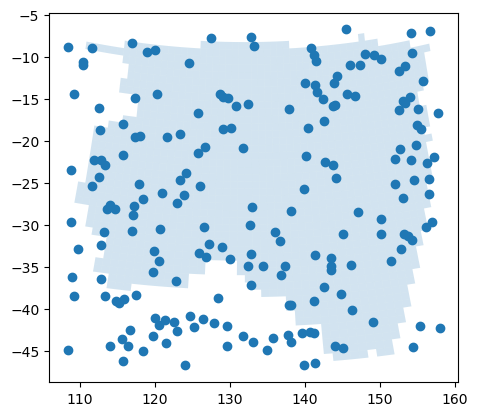

In [5]:
# Generate random data within input bounds
n = 200
x = np.random.uniform(minx, maxx, n)
y = np.random.uniform(miny, maxy, n)

dea_albers.plot(alpha=0.2)
plt.scatter(x, y)

In [16]:
tides_clipped = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model=[
        "FES2022",
        "TPXO8-atlas-v1",
        "TPXO9-atlas-v5",
        "FES2014",
        "FES2012",
        "EOT20",
        "HAMTIDE11",
    ],
    directory="/gdata1/data/tide_models_clipped",
)

tides_original = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model=[
        "FES2022",
        "TPXO8-atlas-v1",
        "TPXO9-atlas-v5",
        "FES2014",
        "FES2012",
        "EOT20",
        "HAMTIDE11",
    ],
    directory="/gdata1/data/tide_models",
)

# Add original tides as new column and plot
tides_clipped["tide_m_original"] = tides_original.tide_m

Modelling tides using FES2022, TPXO8-atlas-v1, TPXO9-atlas-v5, FES2014, FES2012, EOT20, HAMTIDE11 in parallel


100%|██████████| 35/35 [00:42<00:00,  1.22s/it]


Modelling tides using FES2022, TPXO8-atlas-v1, TPXO9-atlas-v5, FES2014, FES2012, EOT20, HAMTIDE11 in parallel


100%|██████████| 35/35 [03:57<00:00,  6.77s/it]  


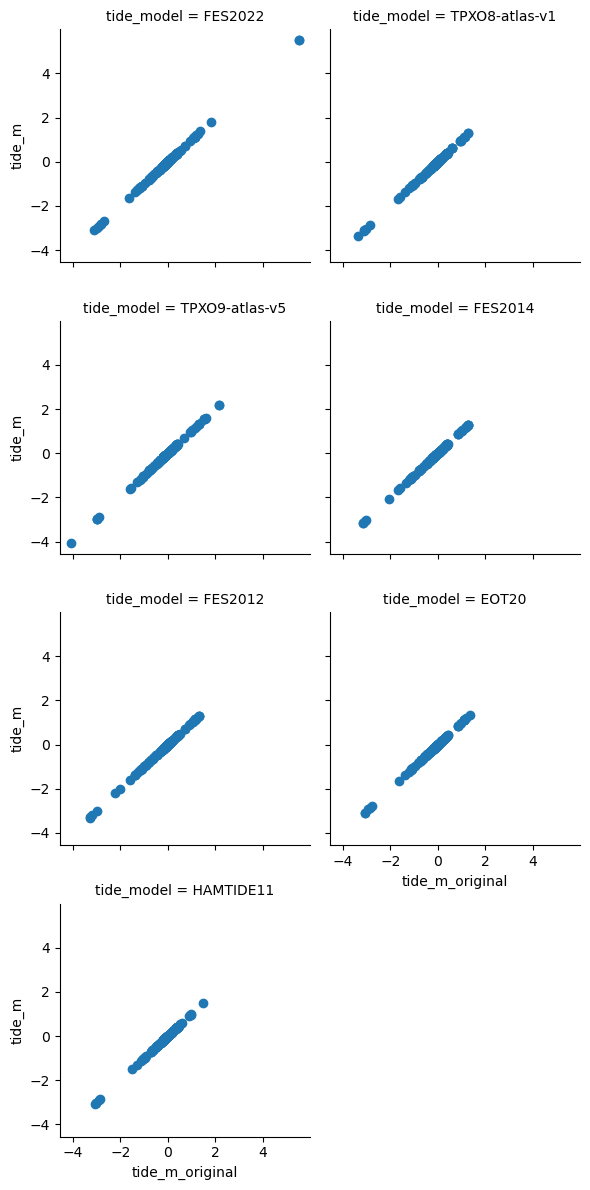

In [17]:
# Plot
g = sns.FacetGrid(tides_clipped, col="tide_model", col_wrap=2)
g = g.map(plt.scatter, "tide_m_original", "tide_m")

In [18]:
accuracy_df = tides_clipped.groupby("tide_model")[
    ["tide_m_original", "tide_m"]
].apply(lambda x: eval_metrics(x=x.tide_m_original, y=x.tide_m))
accuracy_df

,Correlation,RMSE,MAE,R-squared,Bias,Regression slope
tide_model,,,,,,
EOT20,1.0,0.0,0.0,1.0,0.0,1.0
FES2012,1.0,0.0,0.0,1.0,0.0,1.0
FES2014,1.0,0.0,0.0,1.0,0.0,1.0
FES2022,1.0,0.0,0.0,1.0,0.0,1.0
HAMTIDE11,1.0,0.0,0.0,1.0,0.0,1.0
TPXO8-atlas-v1,1.0,0.0,0.0,1.0,0.0,1.0
TPXO9-atlas-v5,1.0,0.0,0.0,1.0,0.0,1.0
